# Part d) Testing different activation functions and depths of the neural network

You should also test different activation functions for the hidden layers. Try out the Sigmoid, the RELU and the Leaky RELU functions and discuss your results. Test your results as functions of the number of hidden layers and nodes. Do you see signs of overfitting? It is optional in this project to perform a bias-variance trade-off analysis.

In [1]:
import sys, os
from pathlib import Path
import matplotlib.pyplot as plt
import time
import autograd.numpy as np
import numpy as np
from autograd import grad, elementwise_grad
from typing import Tuple, List
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from functions import *

%load_ext autoreload
%autoreload 2

# For reproducibility
np.random.seed(42)

# For plotting
import matplotlib.style as mplstyle

mplstyle.use(["ggplot", "fast"])

plt.rcParams.update({
    'font.size': 16,          
    'axes.titlesize': 18,     
    'axes.labelsize': 16,   
    'xtick.labelsize': 14,  
    'ytick.labelsize': 14,
    'legend.fontsize': 14,    
    'figure.titlesize': 20,   
})

sns.set_context("notebook", font_scale=1.3)
sns.set_style("whitegrid")

In [2]:
n = 200
x = np.linspace(-1, 1, n)
x = x.reshape(-1, 1)

y = runge_function(x) + np.random.normal(0, 0.1, (n,1))

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train_norm = (X_train - X_mean) / X_std
X_test_norm  = (X_test - X_mean) / X_std

**To assess how network depth and width influence network performance, we train the network with different number of hidden layers and different number of nodes per layer. In addition to that, we see how different activation functions in the hidden layers impact the performance.**

In [3]:
layer_options = [1, 2, 3, 4, 5, 6, 7]  # different options for number of hidden layers
node_options = [2, 4, 8, 16, 32, 64, 128]  # different options for number of nodes in each hidden layer
hidden_layers_options = [[n]*l for l in layer_options for n in node_options]
activation_options = [sigmoid, RELU, LRELU]  # different activation functions for hidden layers

batch_size = 20
number_of_epochs = 300
learning_rate = 0.001

**The neural network is trained with the above parameters and the results are stored in a Pandas dataframe. The metric used to assess performance is mean squared error.**

In [ ]:
results = []

for layers in hidden_layers_options:
    for activate in activation_options:

        activation_funcs = [activate]*len(layers) + [identity]  # hidden + output
        activation_ders  = [derivate(activate) for _ in layers] + [derivate(identity)]

        # Initialize network
        nn = NeuralNetwork(
            network_input_size=X_train.shape[1],
            layer_output_sizes=layers + [1],
            activation_funcs=activation_funcs,
            activation_ders=activation_ders,
            cost_fun=mse,
            cost_der=mse_der
        )
        
        # Train network with stochastic gradient descent
        nn.train_SGD(X_train, y_train, epochs=number_of_epochs, learning_rate=learning_rate, batch_size=batch_size)

        y_pred_test = nn._feed_forward(X_test)
        y_pred_train = nn._feed_forward(X_train)
        
        # Compute errors
        train_err = mse(y_pred_train, y_train)
        test_err  = mse(y_pred_test, y_test)
        
        results.append({
            "layers": layers,
            "activation": activate.__name__,
            "y_pred_test": y_pred_test,
            "y_pred_train": y_pred_train,
            "train_error": train_err,
            "test_error": test_err
        })

df = pd.DataFrame(results)

**Plotting the MSE as a function of hidden layers.**

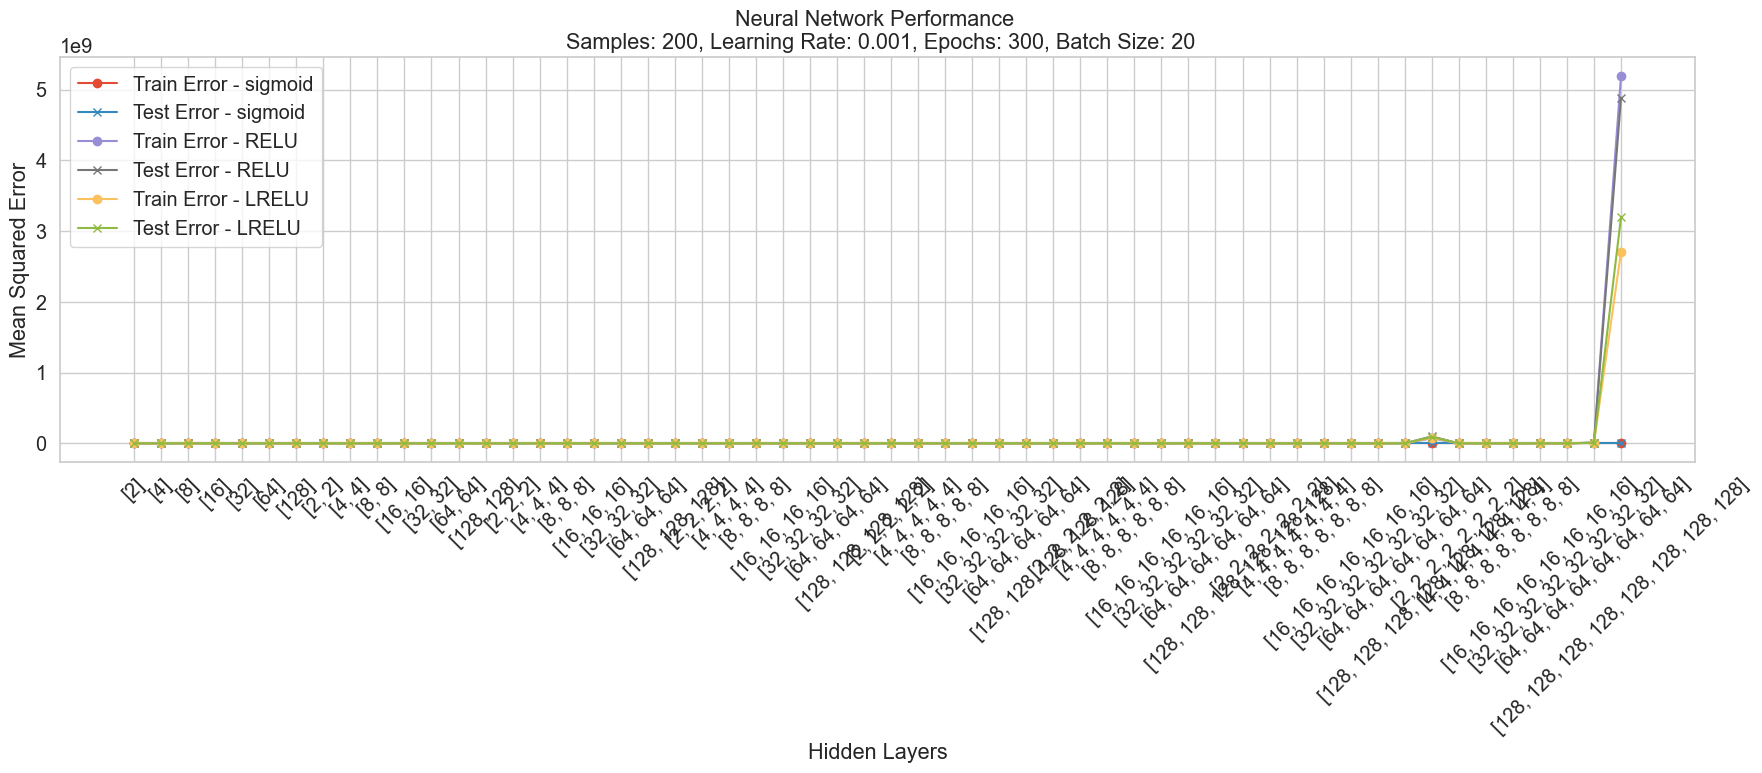

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))

for activate in df['activation'].unique():
    subset = df[df['activation'] == activate]
    ax.plot(subset['layers'].astype(str), subset['train_error'], marker='o', label=f'Train Error - {activate}')
    ax.plot(subset['layers'].astype(str), subset['test_error'], marker='x', label=f'Test Error - {activate}')

ax.set_xlabel("Hidden Layers")
ax.set_ylabel("Mean Squared Error")
ax.set_title(f"Neural Network Performance \n Samples: {n}, Learning Rate: {learning_rate}, Epochs: {number_of_epochs}, Batch Size: {batch_size}")
ax.legend()
plt.xticks(rotation=45)
plt.grid(True)
fig.tight_layout()

# Kjersti notat til skriving
* Diskuter, 3-gradspolynom ville vi forvente at OLS er bedre. Men Runge er vanskelig å få til i endepunktene, så her er nok NN bedre enn OLS og andre klassiske regresjonsmetoder.
* Dette er universal approksimasjonsteoreom i praksis. Vi vet vi kan approksimere til en viss feil, med minst et lag. Diskusjon!

Sigmoid function, returns outputs between 0 and 1. 
* Useful for probabilisitic classification.
* Can be computationally costly.
* During training, the sigmoid function can cause gradients to become very small, which slows down learning, especially in deep networks.

ReLU (Rectified Linear Unit), returns the input it recieves if the value is positive. Returns zero otherwise.
* Fast to compute
* Introduces nonlinearity
* Mitigates vanishing gradient problem. If the input is positive, the gradient is a constant 1. Helps prevent gradients becoming too small during backpropagation and allows for faster learning.
* If a neuron consistently receives negative inputs, it can get stuck in a state where it always outputs zero. Because the gradient is also zero, its weights are never updated, and the neuron becomes inactive (dies).

LReLU (Leaky Rectified Linear Unit), also outputs the input if it is positive, but instead of zero for negative inputs it returns a small fraction. 
* Main purpose to prevent dying neurons.
* Leads to more stable and consistent training.

**There are clear signs of overfitting in the cases where the network is trained with many hidden layers for ReLU activation function. Let's zoom in on the y axis to see what happens more clearly.**

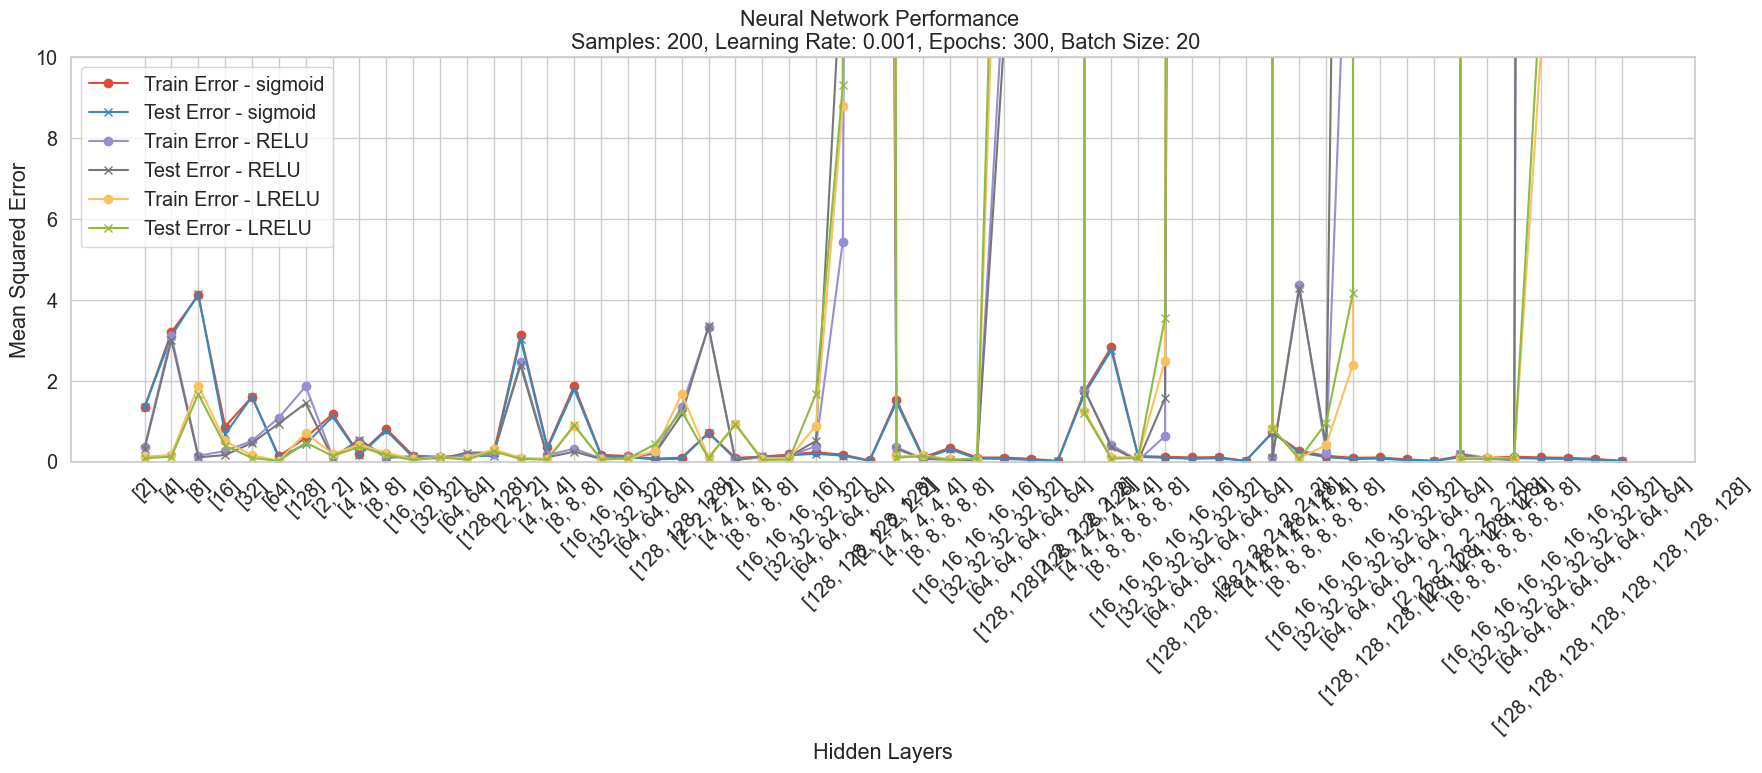

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))

for activate in df['activation'].unique():
    subset = df[df['activation'] == activate]
    ax.plot(subset['layers'].astype(str), subset['train_error'], marker='o', label=f'Train Error - {activate}')
    ax.plot(subset['layers'].astype(str), subset['test_error'], marker='x', label=f'Test Error - {activate}')

ax.set_ylim(0, 10)

ax.set_xlabel("Hidden Layers")
ax.set_ylabel("Mean Squared Error")
ax.set_title(f"Neural Network Performance \n Samples: {n}, Learning Rate: {learning_rate}, Epochs: {number_of_epochs}, Batch Size: {batch_size}")
ax.legend()
plt.xticks(rotation=45)
plt.grid(True)
fig.tight_layout()

# Kjersti notat til skriving
* Sigmoid: tends to saturate (vanishing gradients), so performance often degreades with depth (number of hidden layers).
* ReLU: Usually performs best for deeper networks due to non-saturating gradient.
* Leaky ReLU: Often similar to ReLU but better for very deep networks (less dead neurons).

* Increasing nodes/layers usually improves training performance but may increase overfitting.

**Now we plot heatmaps to better see the impact on MSE of the number of nodes and number of hidden layers.**

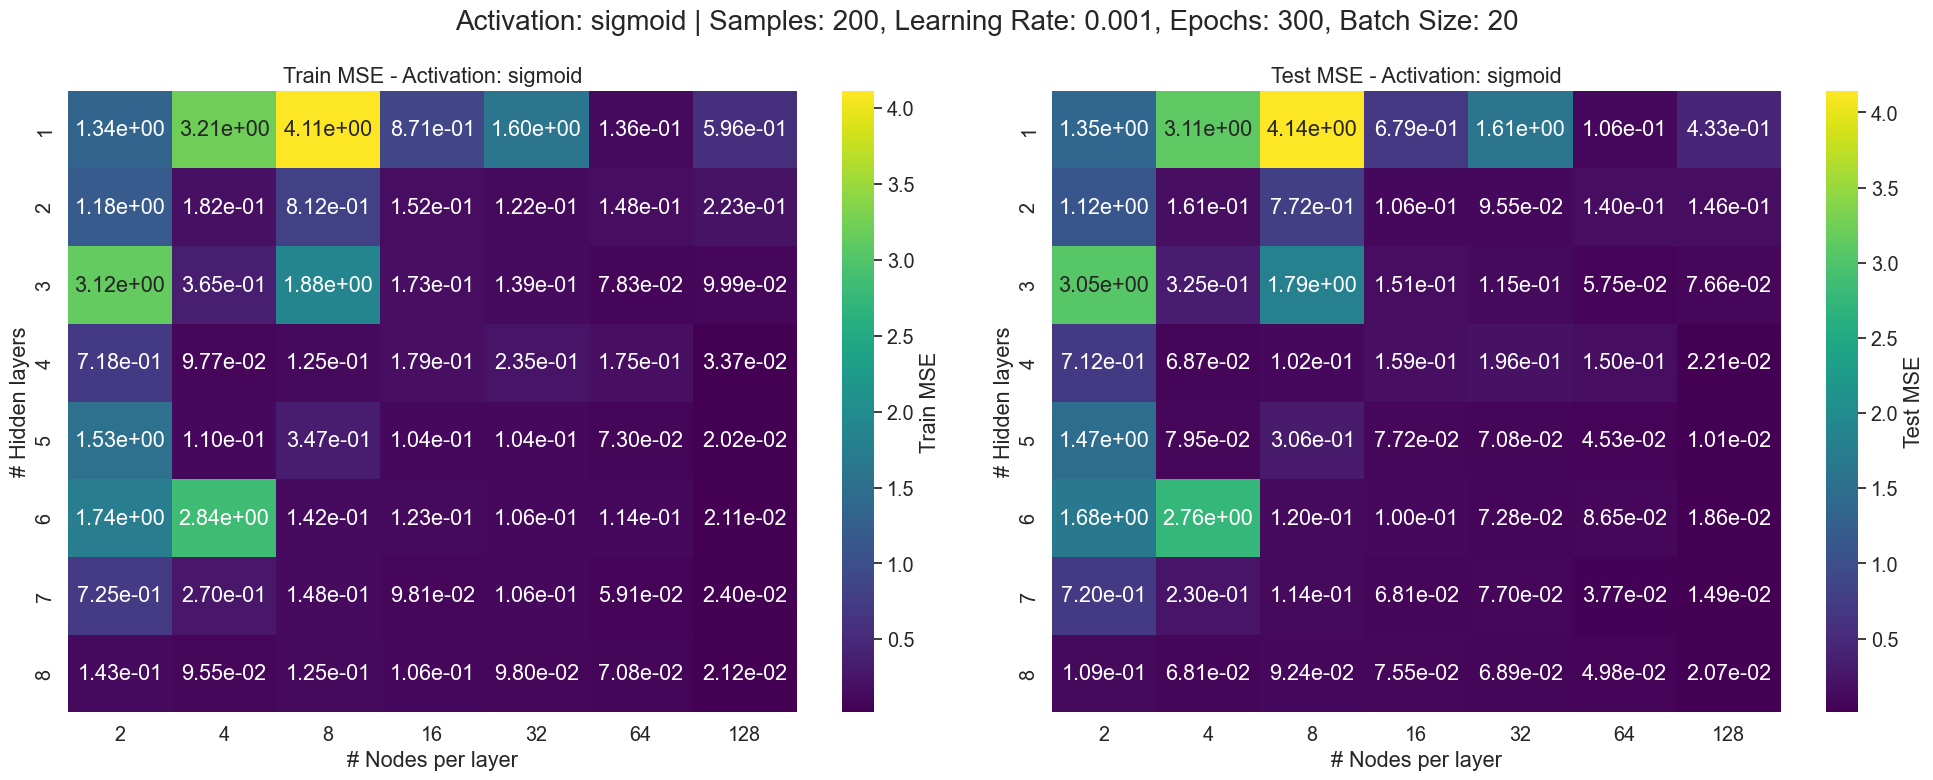

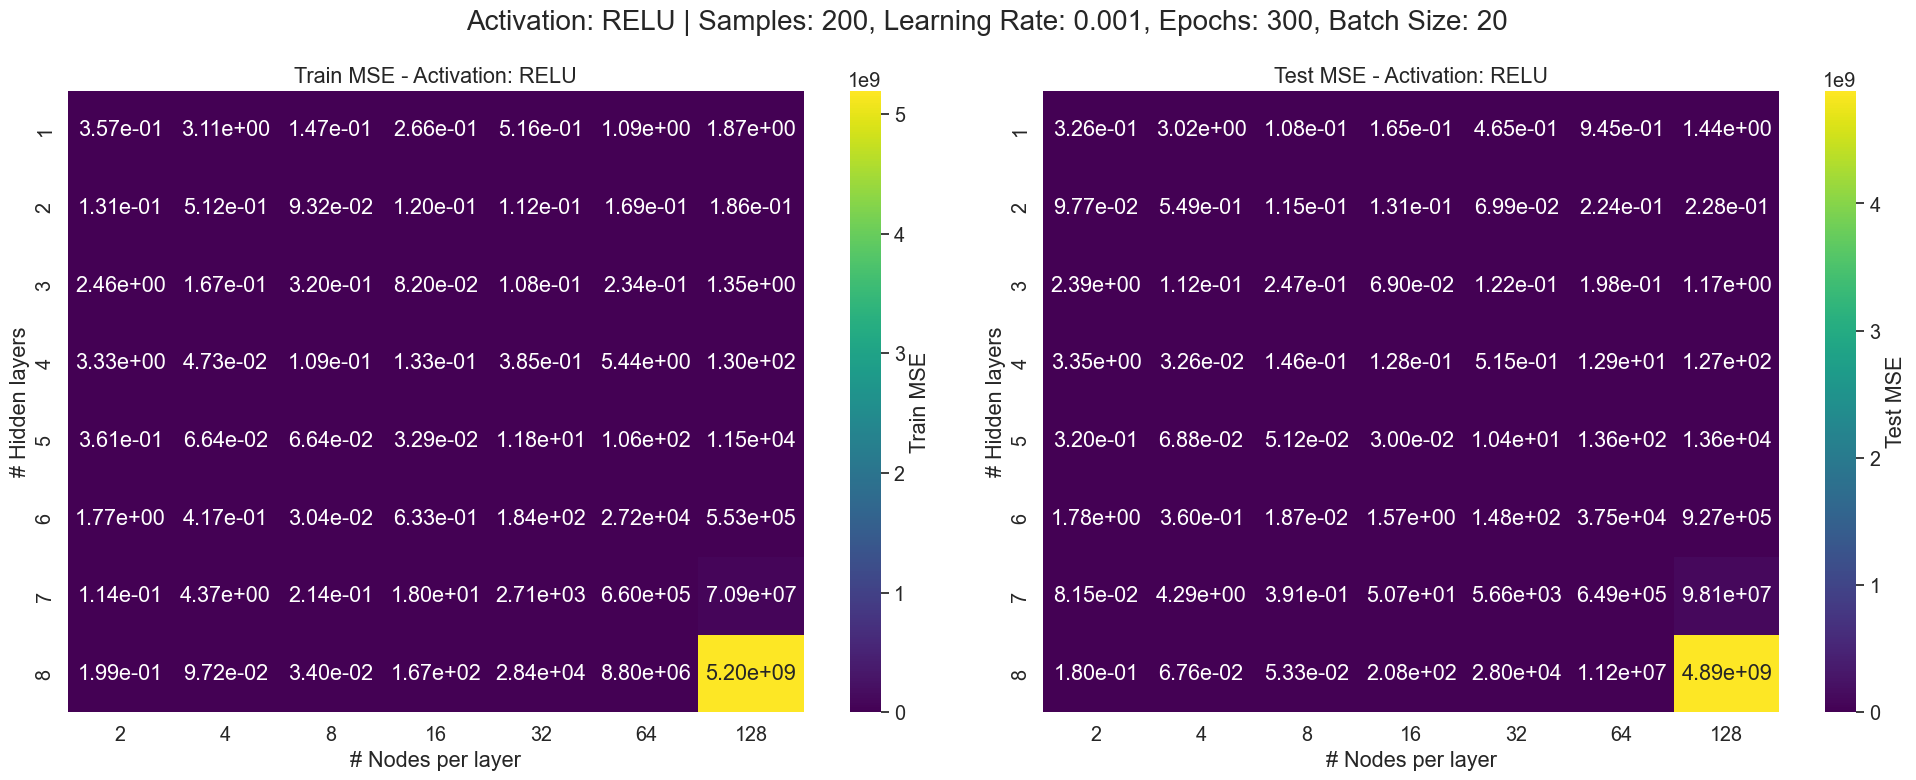

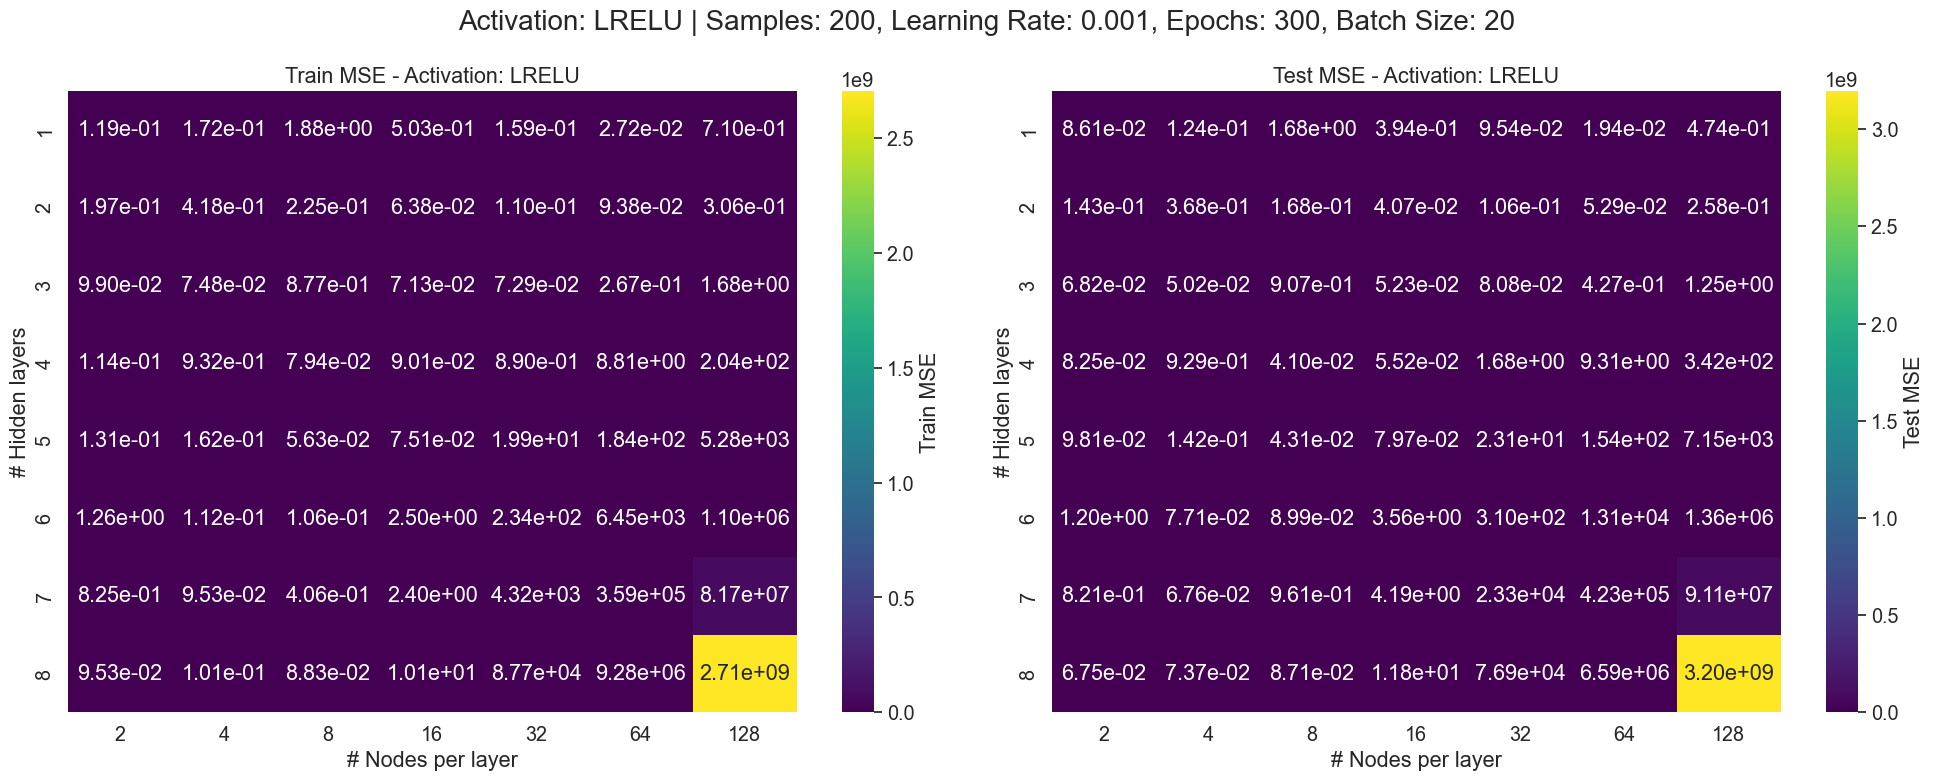

In [ ]:
df["n_hidden_layers"] = df["layers"].apply(len)
df["n_nodes"] = df["layers"].apply(lambda x: x[0])

for act in df["activation"].unique():
    df_plot = df[df["activation"] == act]

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    heatmap_train = df_plot.pivot_table(
        index="n_hidden_layers",
        columns="n_nodes",
        values="train_error",
        aggfunc="mean"
    )
    sns.heatmap(
        heatmap_train,
        annot=True,
        fmt=".2e",
        cmap="viridis",
        cbar_kws={"label": "Train MSE"},
        ax=axes[0]
    )
    axes[0].set_title(f"Train MSE - Activation: {act}")
    axes[0].set_xlabel("# Nodes per layer")
    axes[0].set_ylabel("# Hidden layers")

    heatmap_test = df_plot.pivot_table(
        index="n_hidden_layers",
        columns="n_nodes",
        values="test_error",
        aggfunc="mean"
    )
    sns.heatmap(
        heatmap_test,
        annot=True,
        fmt=".2e",
        cmap="viridis",
        cbar_kws={"label": "Test MSE"},
        ax=axes[1]
    )
    axes[1].set_title(f"Test MSE - Activation: {act}")
    axes[1].set_xlabel("# Nodes per layer")
    axes[1].set_ylabel("# Hidden layers")

    fig.suptitle(f"Activation: {act} | Samples: {n}, Learning Rate: {learning_rate}, Epochs: {number_of_epochs}, Batch Size: {batch_size}")

    plt.tight_layout()


**Finding the architectures with the lowest MSE.**

In [ ]:
best_sigmoid_test = df[df["activation"] == "sigmoid"].sort_values("test_error").iloc[0]
best_RELU_test = df[df["activation"] == "RELU"].sort_values("test_error").iloc[0]
best_LRELU_test = df[df["activation"] == "LRELU"].sort_values("test_error").iloc[0]

best_sigmoid_train = df[df["activation"] == "sigmoid"].sort_values("train_error").iloc[0]
best_RELU_train = df[df["activation"] == "RELU"].sort_values("train_error").iloc[0]
best_LRELU_train = df[df["activation"] == "LRELU"].sort_values("train_error").iloc[0]

In [ ]:
print("Best NN architectures for different activation functions:")
print("----------------------------------------------------------")
print("Sigmoid, assessed for MSE on the training data:", best_sigmoid_train)
print()
print("RELU, assessed for MSE on the training data:", best_RELU_train)
print()
print("LRELU, assessed for MSE on the training data:", best_LRELU_train)

Best NN architectures for different activation functions:
----------------------------------------------------------
Sigmoid, assessed for MSE on the training data: layers                                     [128, 128, 128, 128, 128]
activation                                                   sigmoid
y_pred_test        [[0.830258045750274], [0.09861522731325456], [...
y_pred_train       [[0.5576609713386458], [0.12041964247963222], ...
train_error                                                  0.02018
test_error                                                  0.010112
n_hidden_layers                                                    5
n_nodes                                                          128
Name: 102, dtype: object

RELU, assessed for MSE on the training data: layers                                            [8, 8, 8, 8, 8, 8]
activation                                                      RELU
y_pred_test        [[0.6876000459504372], [-0.14332582876681932],...
y_pre

In [ ]:
print("Best NN architectures for different activation functions:")
print("----------------------------------------------------------")
print("Sigmoid, assessed for MSE on the test data:", best_sigmoid_test)
print()
print("RELU, assessed for MSE on the test data:", best_RELU_test)
print()
print("LRELU, assessed for MSE on the test data:", best_LRELU_test)

Best NN architectures for different activation functions:
----------------------------------------------------------
Sigmoid, assessed for MSE on the test data: layers                                     [128, 128, 128, 128, 128]
activation                                                   sigmoid
y_pred_test        [[0.830258045750274], [0.09861522731325456], [...
y_pred_train       [[0.5576609713386458], [0.12041964247963222], ...
train_error                                                  0.02018
test_error                                                  0.010112
n_hidden_layers                                                    5
n_nodes                                                          128
Name: 102, dtype: object

RELU, assessed for MSE on the test data: layers                                            [8, 8, 8, 8, 8, 8]
activation                                                      RELU
y_pred_test        [[0.6876000459504372], [-0.14332582876681932],...
y_pred_train 

# Part e) Testing different norms

##### 1) Find the optimal parameters for the neural network

Still using the **one-dimensional Runge function**, add now the
hyperparameters $\lambda$ with the $L_2$ and $L_1$ norms.  Find the
optimal results for the hyperparameters $\lambda$ and the learning
rates $\eta$ and neural network architecture.

##### 2) Compare to project 1

Compare the $L_2$ results with **Ridge** regression from project 1 and the $L_1$ results with the **Lasso** calculations of project 1. Use again the same data sets and the best results from project 1 in your comparisons.

**Now we use the best architectures found from part d to assess the hyperparameters with added norms. The best architecture per activation function type is chosen as the option which yielded the lowest MSE on the test data.**

In [ ]:
best_architectures = {
    "sigmoid":  [128, 128, 128, 128, 128],
    "RELU": [8, 8, 8, 8, 8, 8],
    "LRELU": [64]
}

activation_funcs = {
    "sigmoid": sigmoid,
    "RELU": RELU,
    "LRELU": LRELU
}

lambda_options = [0.0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
learning_rate_options = [0.001, 0.01, 0.1, 1.0, 1.01, 1.1, 1.5, 2.0]

**Using the best architectures, we now train the neural network with different options for hyperparameter $\lambda$ and different values for the learning rate $\eta$.**

In [ ]:
results_reg = []

for act_name, layers in best_architectures.items():
    for reg_type in ["L1","L2"]:
        for lamb in lambda_options:
            for lr in learning_rate_options:
                activate = activation_funcs[act_name]
                
                activation_funcs_list = [activate]*len(layers) + [identity]
                activation_ders_list  = [derivate(activate) for _ in layers] + [derivate(identity)]
                
                nn = NeuralNetwork(
                    network_input_size=X_train.shape[1],
                    layer_output_sizes=layers + [1],
                    activation_funcs=activation_funcs_list,
                    activation_ders=activation_ders_list,
                    cost_fun=mse,
                    cost_der=mse_der,
                    lamb=lamb,
                    cost_fun_type=reg_type
                )

                nn.train_SGD(X_train_norm, y_train, epochs=number_of_epochs, learning_rate=lr, batch_size=batch_size)

                y_pred_test = nn._feed_forward(X_test_norm)
                y_pred_train = nn._feed_forward(X_train_norm)
                
                results_reg.append({
                    "architecture": act_name,
                    "layers": layers,
                    "activation": act_name,
                    "reg_type": reg_type,
                    "lambda": lamb,
                    "learning_rate": lr,
                    "train_error": mse(y_pred_train, y_train),
                    "test_error": mse(y_pred_test, y_test)
                })

df_reg = pd.DataFrame(results_reg)

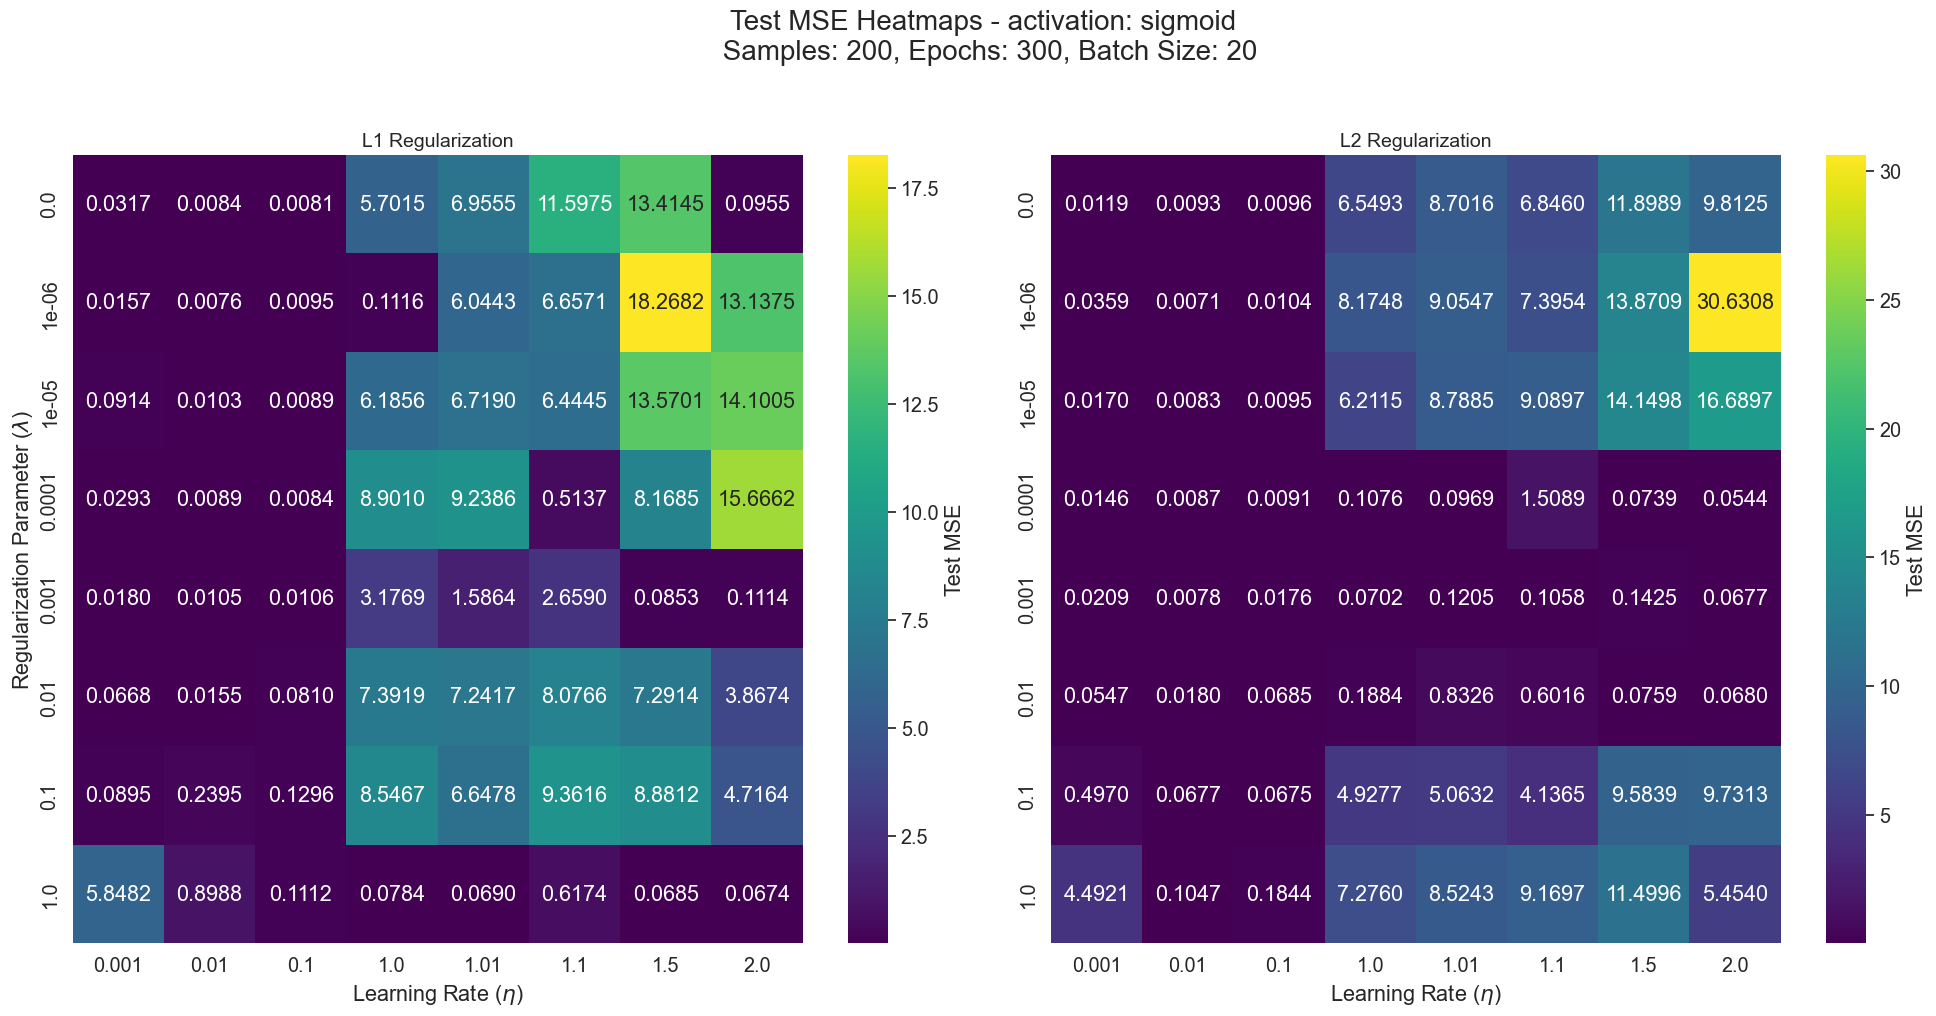

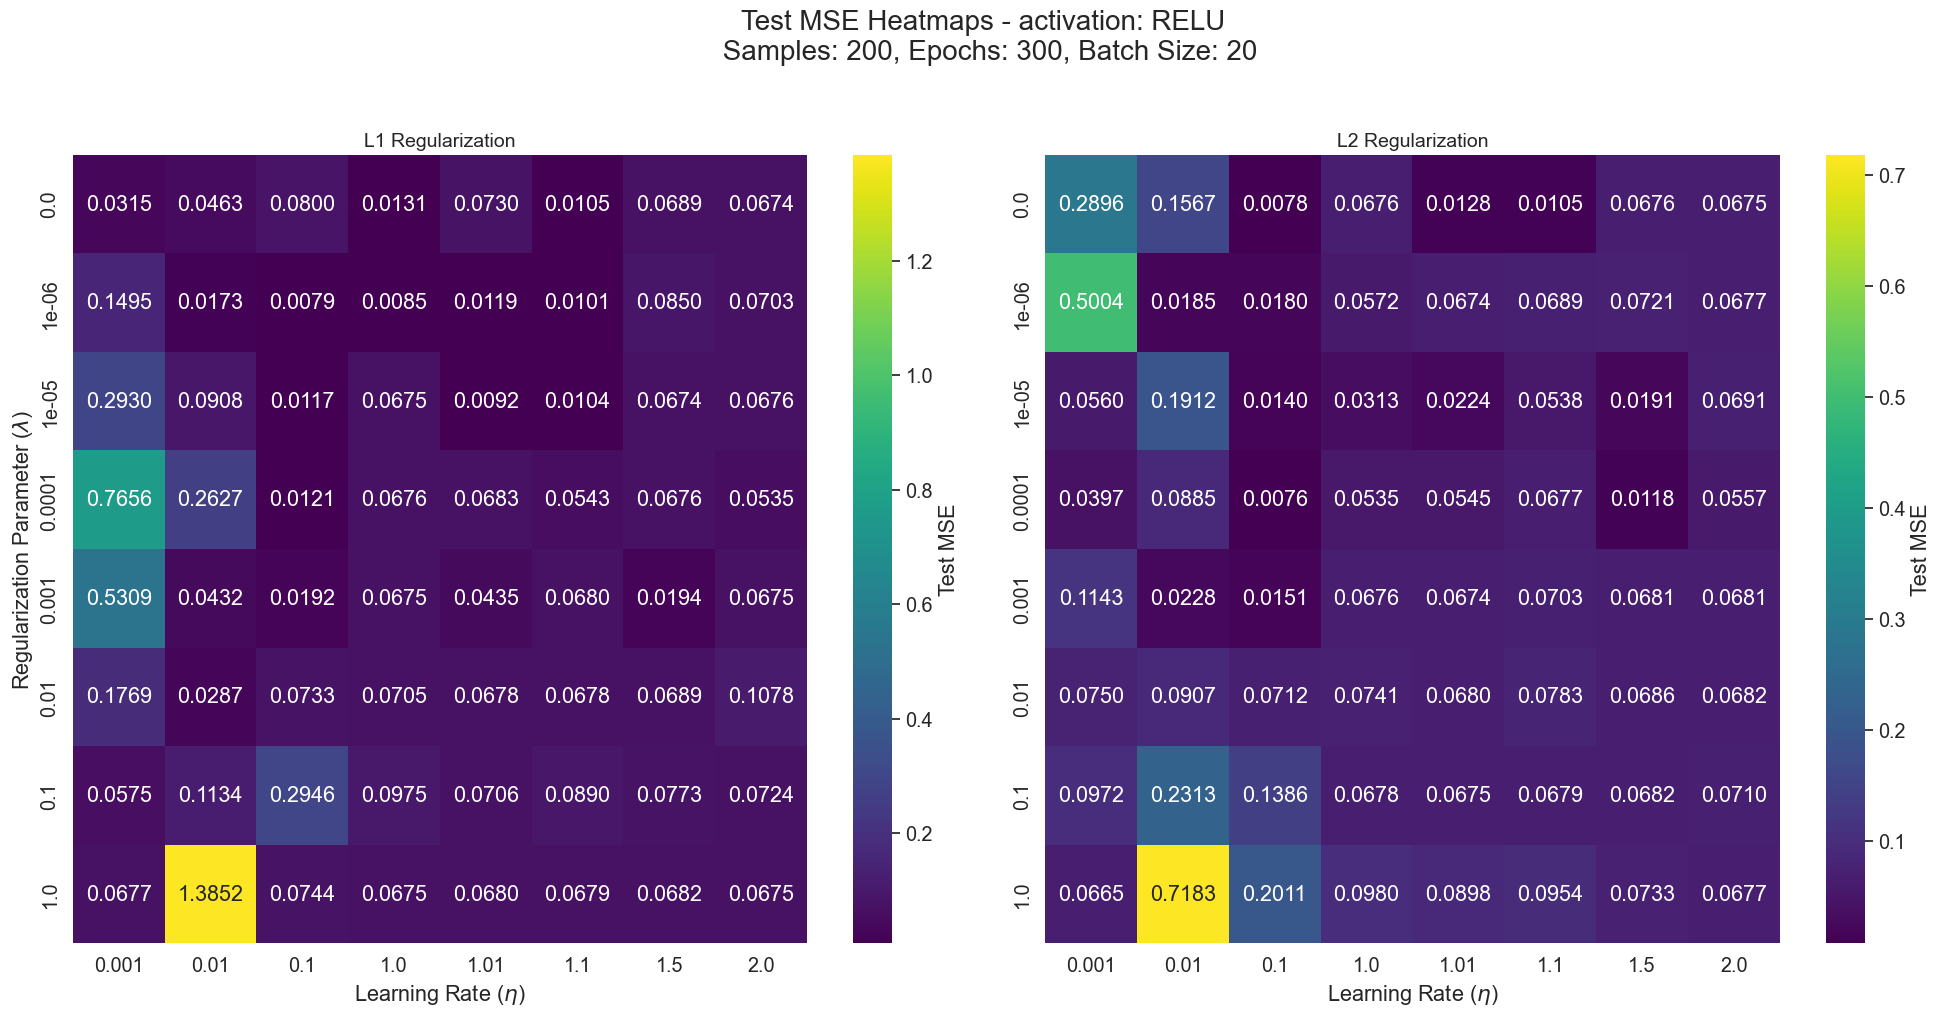

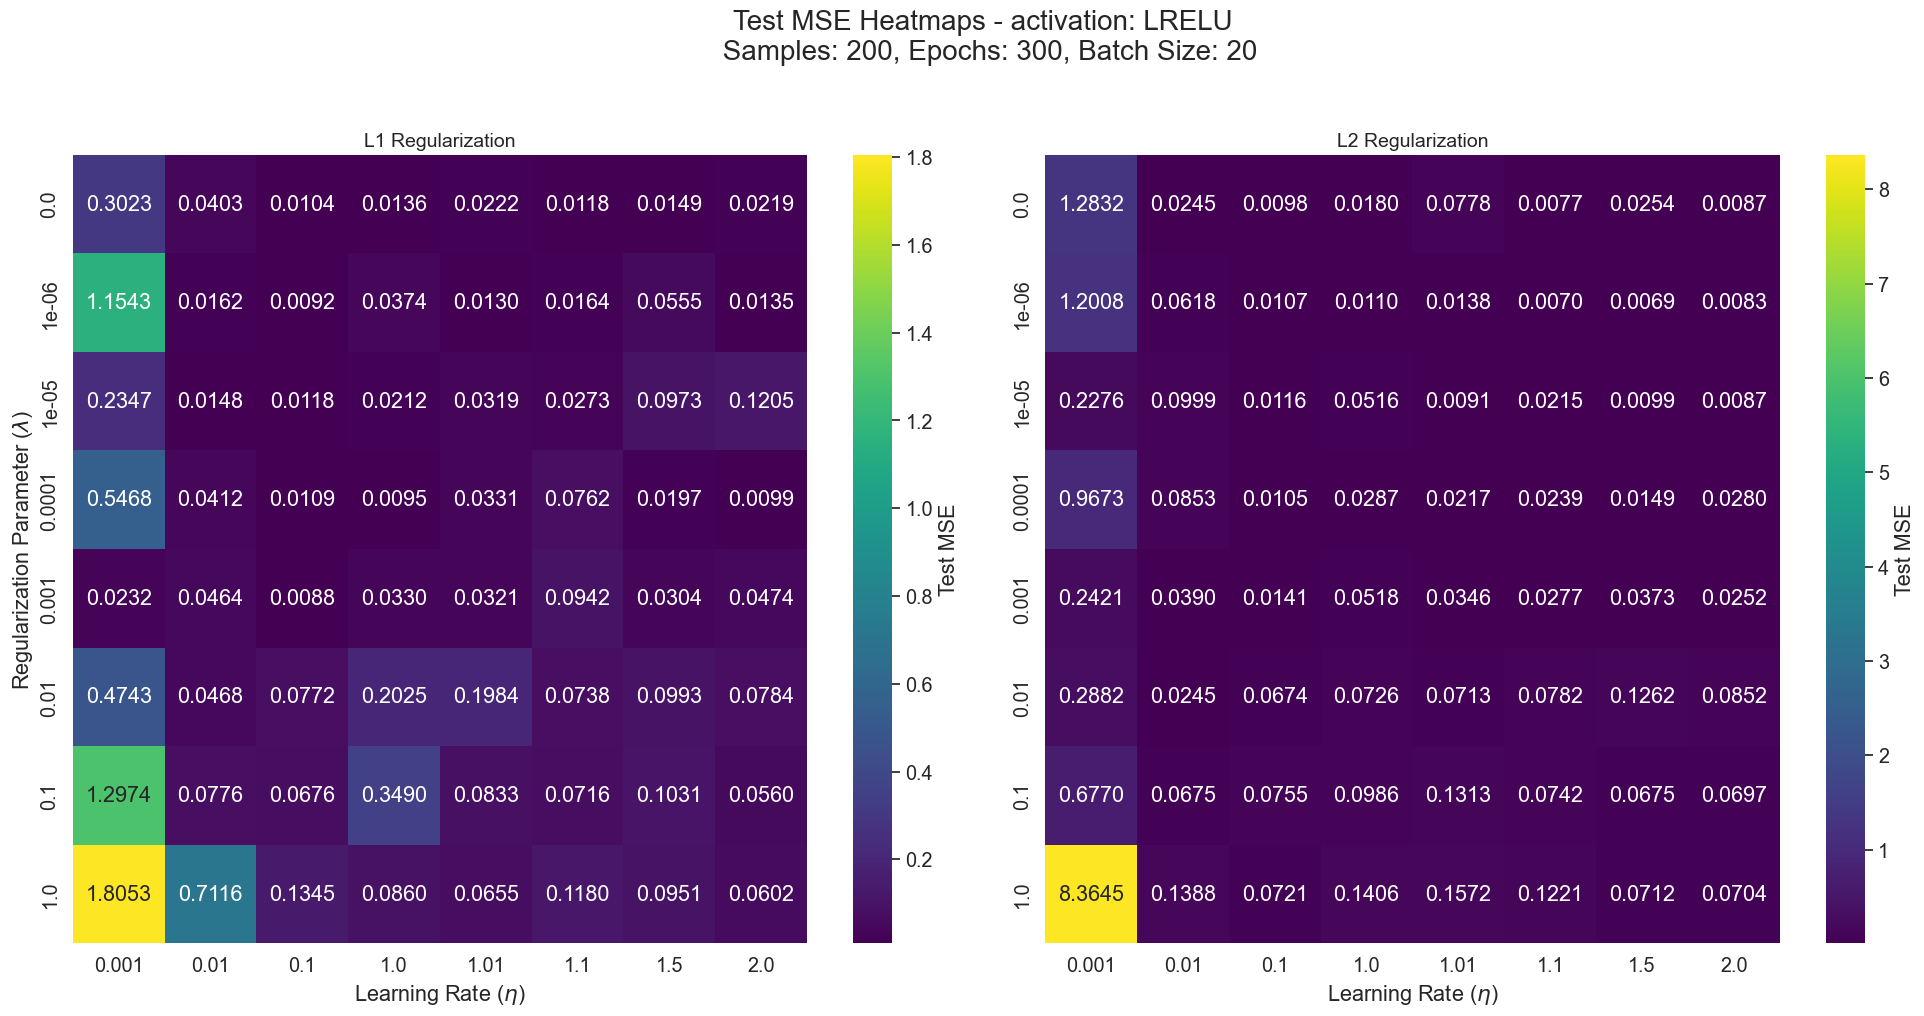

In [ ]:
for arch in df_reg["architecture"].unique():
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    for ax, reg_type in zip(axes, ["L1", "L2"]):
        df_plot = df_reg[
            (df_reg["architecture"] == arch) &
            (df_reg["reg_type"] == reg_type)
        ]
    
        heatmap_data = df_plot.pivot_table(
            index="lambda",
            columns="learning_rate",
            values="test_error",
            aggfunc="mean"
        )
        
        sns.heatmap(
            heatmap_data,
            annot=True,
            fmt=".4f",
            cmap="viridis",
            cbar_kws={"label": "Test MSE"},
            ax=ax
        )
        
        ax.set_title(f"{reg_type} Regularization", fontsize=14)
        ax.set_xlabel(r"Learning Rate ($\eta$)")
        if reg_type == "L1":
            ax.set_ylabel(r"Regularization Parameter ($\lambda$)")
        else:
            ax.set_ylabel("")

    fig.suptitle(f"Test MSE Heatmaps - activation: {arch} \n Samples: {n}, Epochs: {number_of_epochs}, Batch Size: {batch_size}", y=1.02)
    plt.tight_layout()

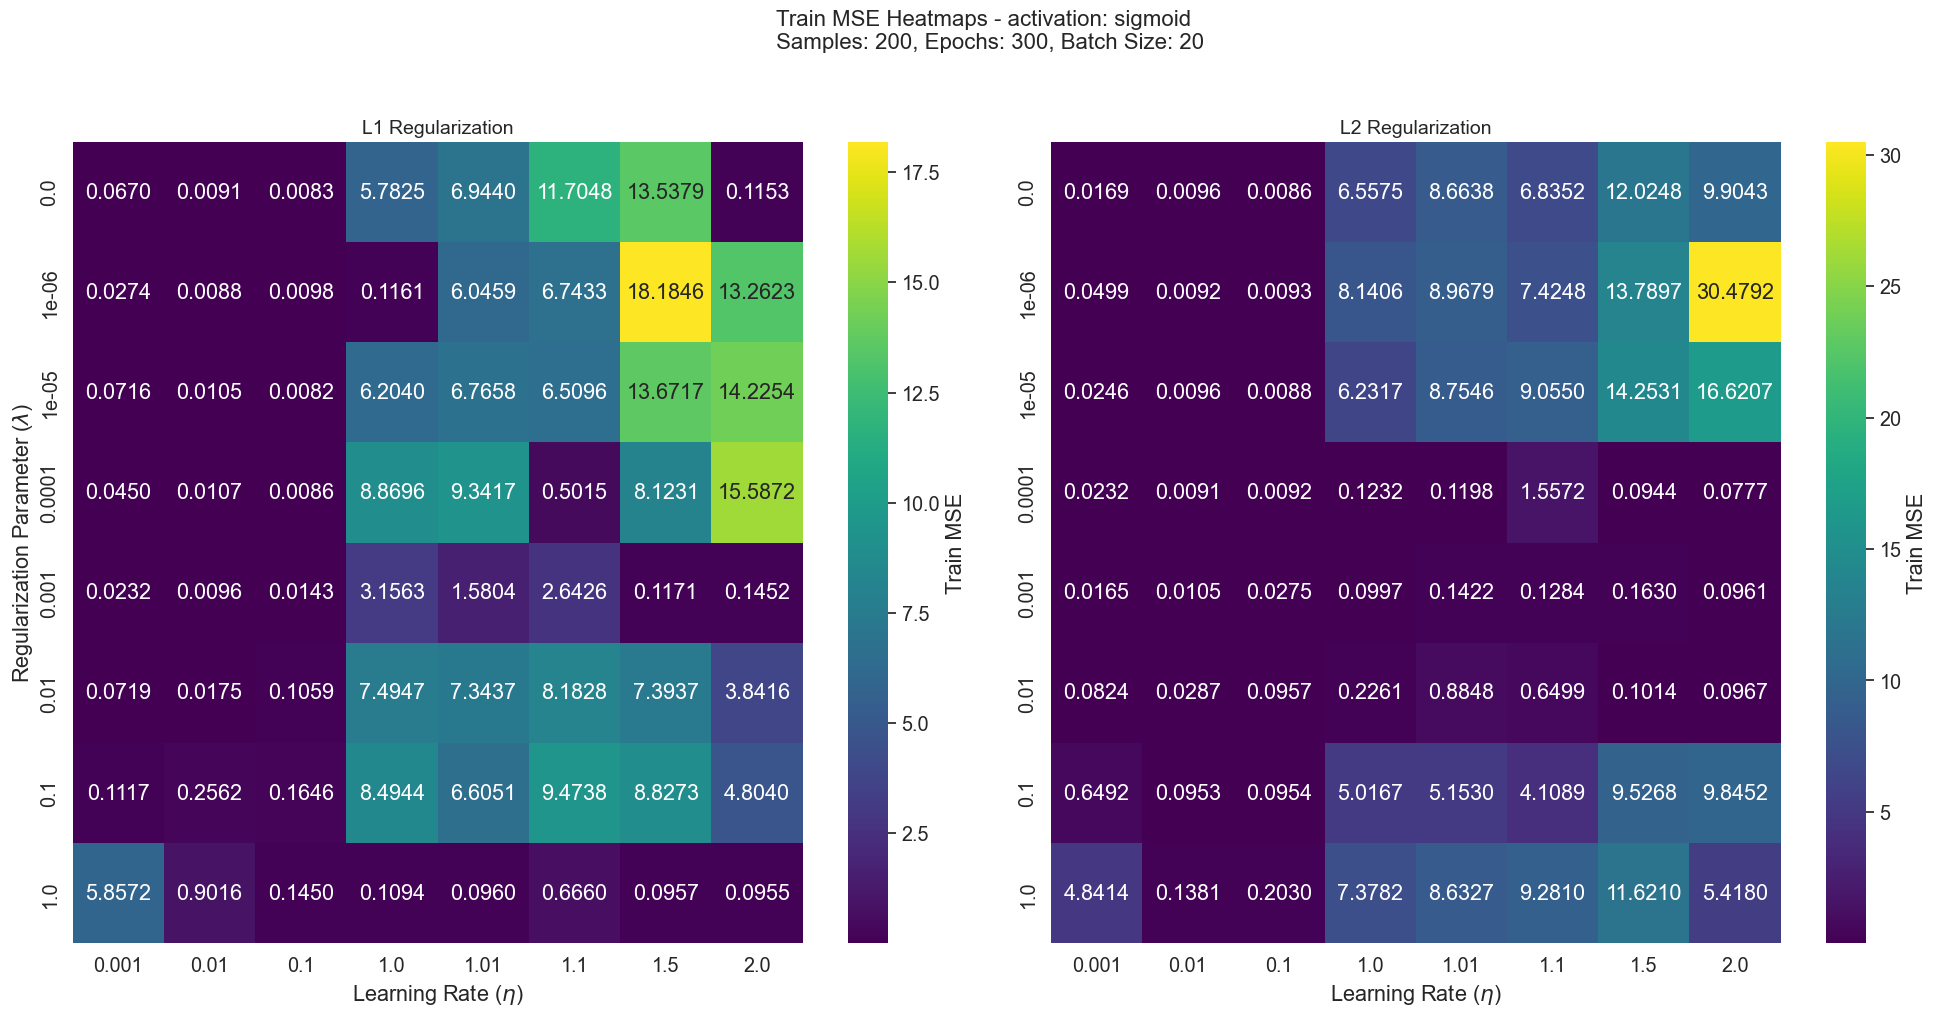

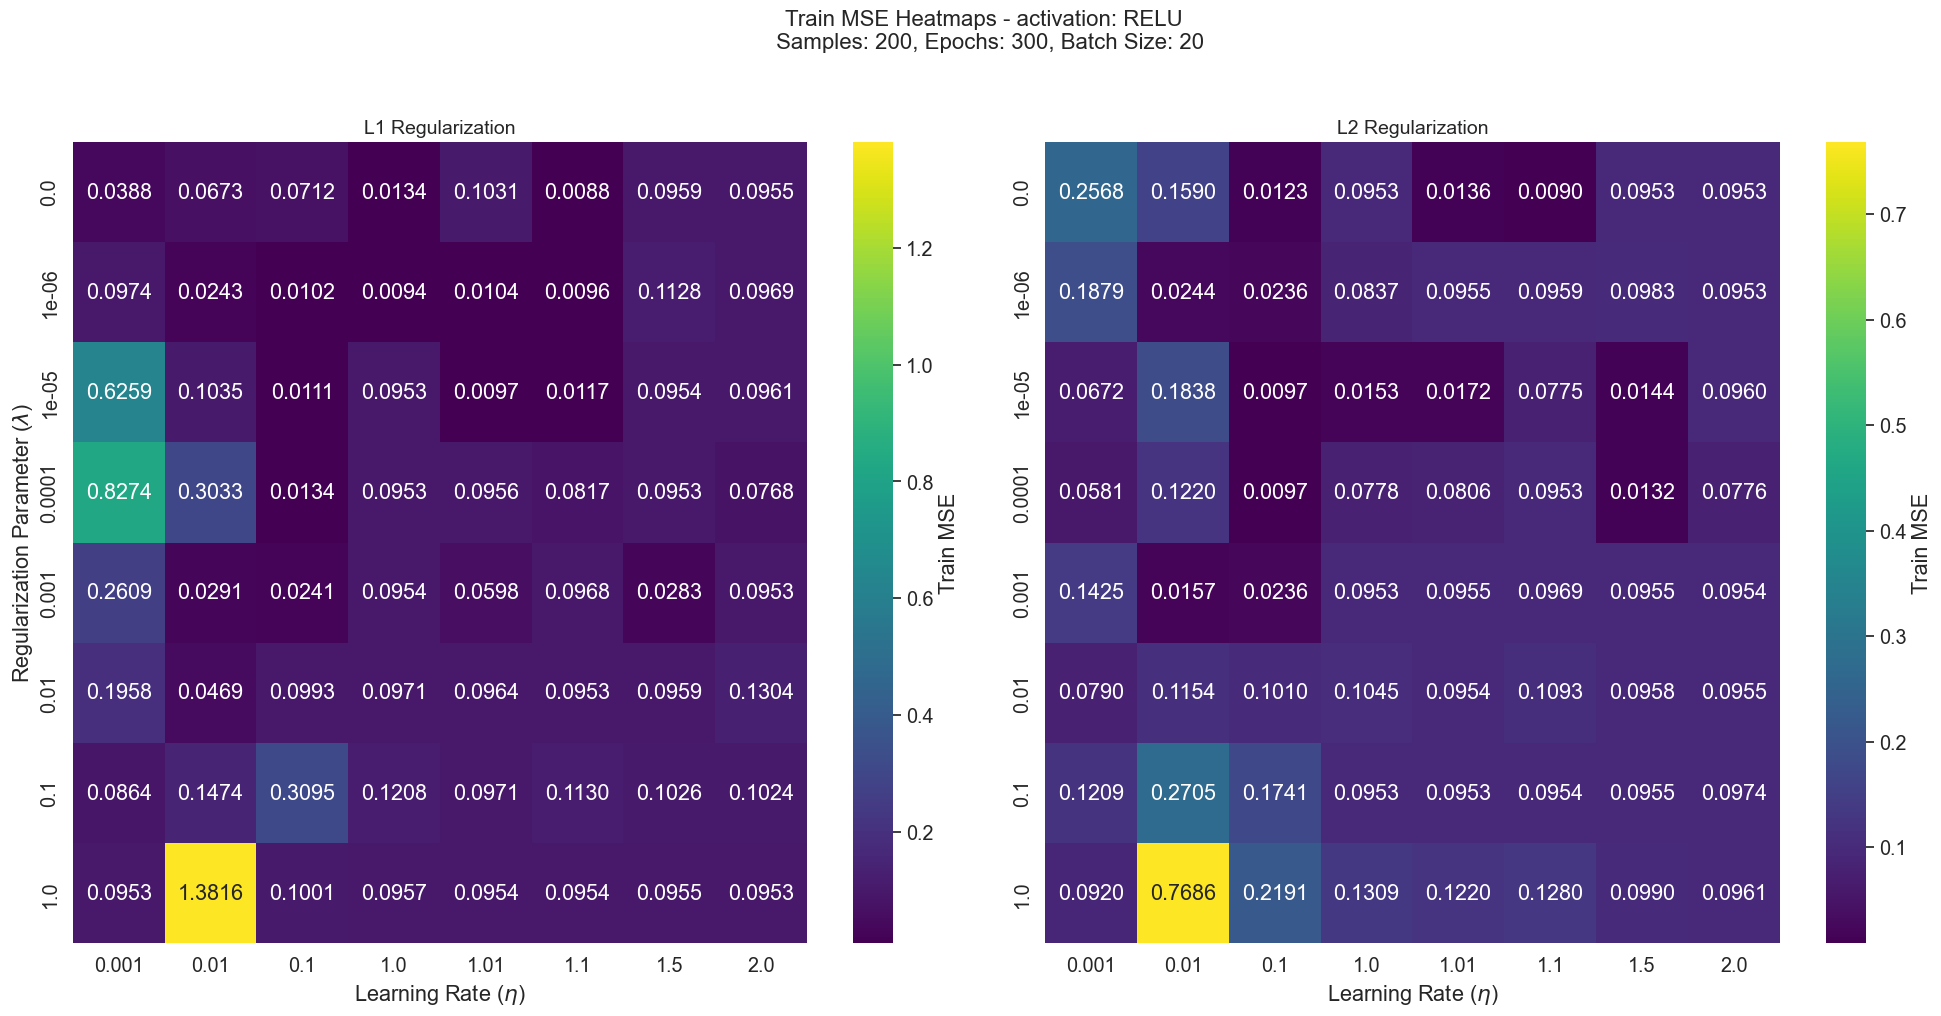

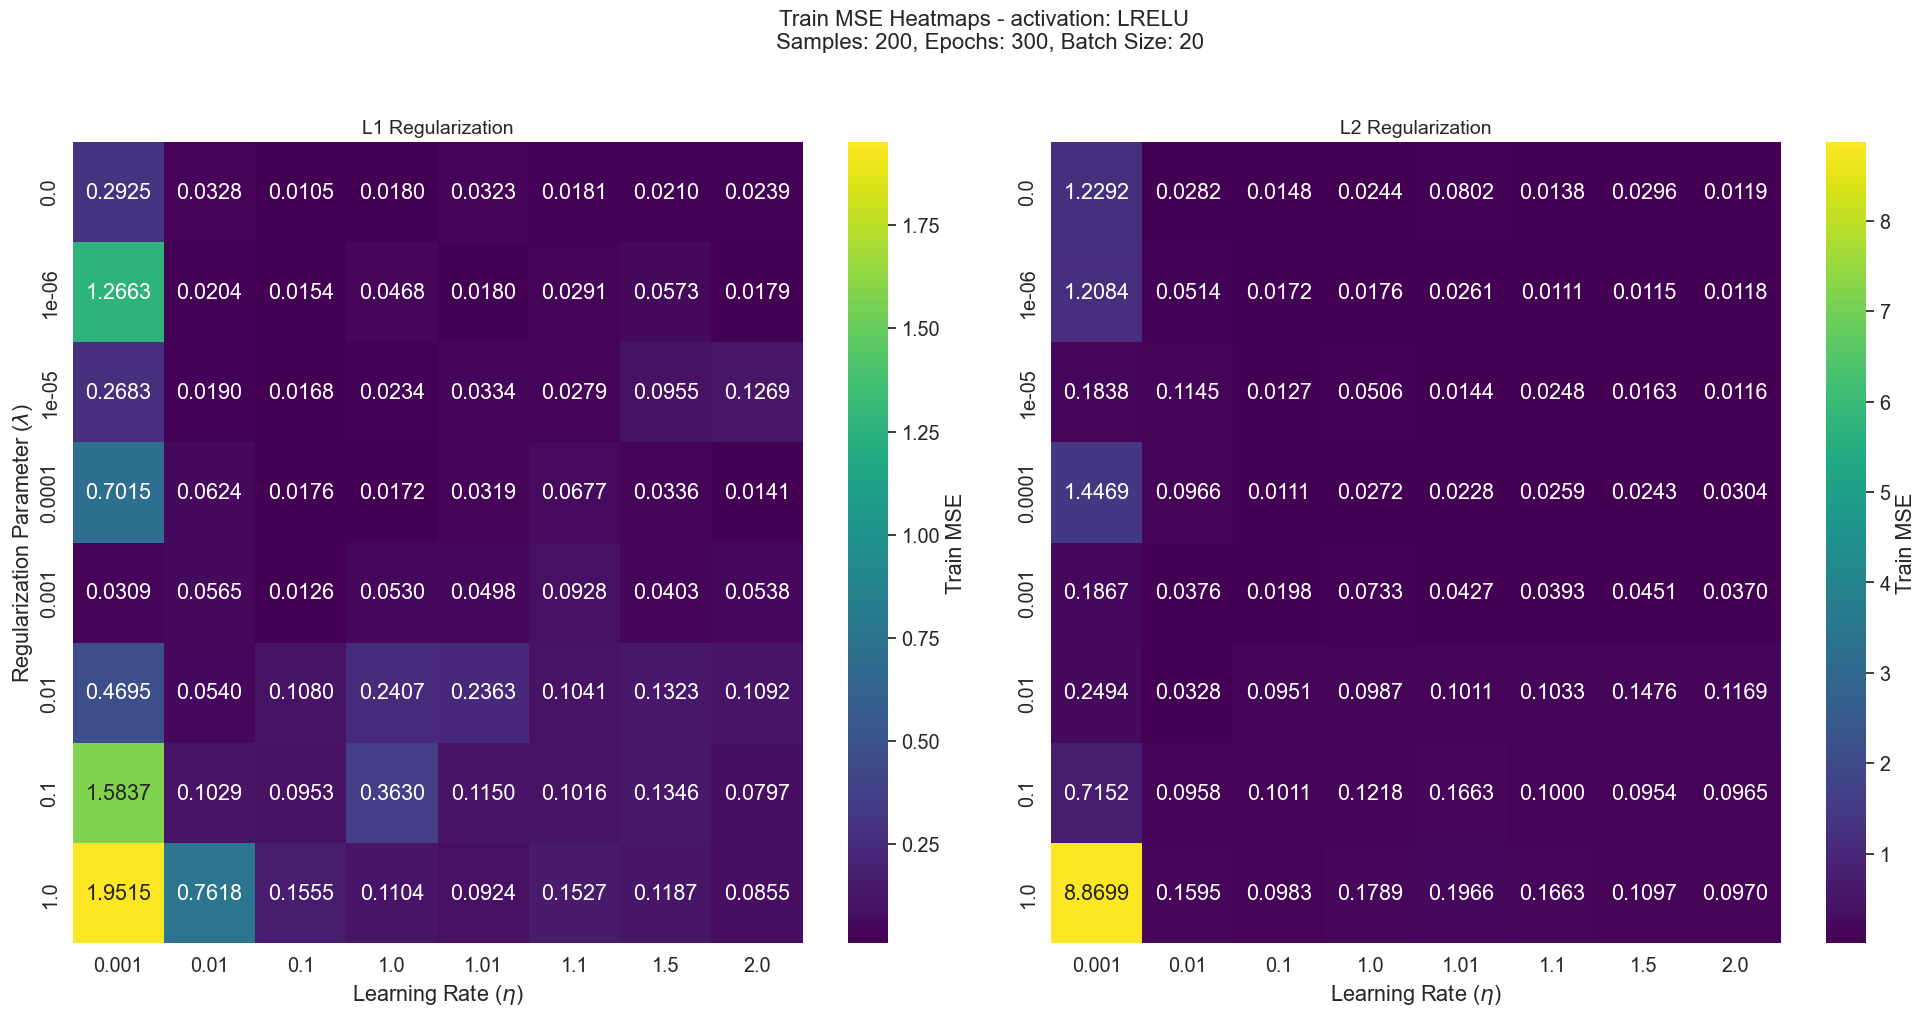

In [ ]:
for arch in df_reg["architecture"].unique():
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    for ax, reg_type in zip(axes, ["L1", "L2"]):
        df_plot = df_reg[
            (df_reg["architecture"] == arch) &
            (df_reg["reg_type"] == reg_type)
        ]
    
        heatmap_data = df_plot.pivot_table(
            index="lambda",
            columns="learning_rate",
            values="train_error",
            aggfunc="mean"
        )
        
        sns.heatmap(
            heatmap_data,
            annot=True,
            fmt=".4f",
            cmap="viridis",
            cbar_kws={"label": "Train MSE"},
            ax=ax
        )
        
        ax.set_title(f"{reg_type} Regularization", fontsize=14)
        ax.set_xlabel(r"Learning Rate ($\eta$)")
        if reg_type == "L1":
            ax.set_ylabel(r"Regularization Parameter ($\lambda$)")
        else:
            ax.set_ylabel("")

    fig.suptitle(f"Train MSE Heatmaps - activation: {arch} \n Samples: {n}, Epochs: {number_of_epochs}, Batch Size: {batch_size}", fontsize=16, y=1.02)
    plt.tight_layout()

In [ ]:
# Best network for each combination
best_L2 = df_reg[df_reg["reg_type"]=="L2"].sort_values("test_error").iloc[0]
best_L1 = df_reg[df_reg["reg_type"]=="L1"].sort_values("test_error").iloc[0]

print("Best L2 network:")
print(best_L2[["architecture", "layers", "lambda", "learning_rate", "train_error", "test_error"]])
print('-'*50)
print("Best L1 network:")
print(best_L1[["architecture", "layers", "lambda", "learning_rate", "train_error", "test_error"]])
print()
print('-'*50)
for act in df_reg["activation"].unique():
    df_act = df_reg[df_reg["activation"] == act]
    
    # Find the row with minimum test error
    best_row = df_act.loc[df_act["test_error"].idxmin()]
    
    print(f"Best network for activation: {act}")
    print(best_row[["reg_type", "layers", "lambda", "learning_rate", "train_error", "test_error"]])
    print("-"*50)

Best L2 network:
architecture        LRELU
layers               [64]
lambda           0.000001
learning_rate         1.5
train_error      0.011532
test_error       0.006919
Name: 334, dtype: object
--------------------------------------------------
Best L1 network:
architecture                       sigmoid
layers           [128, 128, 128, 128, 128]
lambda                            0.000001
learning_rate                         0.01
train_error                       0.008799
test_error                        0.007586
Name: 9, dtype: object

--------------------------------------------------
Best network for activation: sigmoid
reg_type                                L2
layers           [128, 128, 128, 128, 128]
lambda                            0.000001
learning_rate                         0.01
train_error                       0.009195
test_error                        0.007099
Name: 73, dtype: object
--------------------------------------------------
Best network for activation: RE

# Kjersti notat til skriving
* Hvis det ikke er "nok" noise i dataen, gir det ikke mening på bruke Lasso og Ridge. Med Lasso og Ridge kommer det et bias, noe OLS ikke har, så om det ikke er særlig med noise vil det være hensiktsmessig for Ridge og Lasso og "bli til OLS" med lambda lik null.
* Her ser vi likevel at det lønner seg med en liten lambda.
* Kan sammenligne med analytisk Ridge og basic Lasso, eller sammenligne med stochastic gradient descent. Gjør det som er mest interessant. 

Above, we are training our neural network with stochastic gradient descent for updating the weights. We use 300 epochs and a batch size of 20 samples. Using the best architectures we found for the three evaluated activation functions, namely:

* Sigmoid with 5 hidden layers and 128 nodes per layer. Test MSE: 0.010112
* ReLU with 6 hidden layers and 8 nodes per layer. Test MSE: 0.018686
* LReLU with 1 hidden layer and 64 nodes per layer. Test MSE: 0.019414

Using these architectures, and applying both an L1 and L2 norm for different values of hyperparameter $\lambda$ and learning rate $\eta$, we find:

* For hidden layers with Sigmoid and the found best architecture, the combination of $\lambda= 10^{-6}$ and $\eta=0.01$, with an $L2$ norm gave the lowest test MSE of 0.007099.
* For hidden layers with ReLU and the found best architecture, the combination of $\lambda= 10^{-4}$ and $\eta=0.1$, with an $L2$ norm gave the lowest test MSE of 0.007565.
* For hidden layers with LReLU and the found best architecture, the combination of $\lambda= 10^{-6}$ and $\eta=1.5$, with an $L2$ norm gave the lowest test MSE of 0.006919.

Here, we tested for 
$\lambda = (0.0, 10^{-6}, 10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 0.1, 1.0)$ and $\eta = (0.001, 0.01, 0.1, 1.0, 1.01, 1.1, 1.5, 2.0)$.

In project 1, we investigated the performance of Ridge and Lasso regression using stochastic gradient descent. With 300 epochs and a batch size of 20 samples, we found that:

**Ridge regression**:
* 
* 